# Introduction
In machine learning, <i>bias</i> refers to the production of consistently prejudiced outcomes by the algorithm, which can create unfair circumstances on multiple fronts. In this blog post, we aim to explore that <i>bias</i> by:
<ol>
    <li> Creating a machine learning model that predicts an individual characteristic like: employment status or income, on the basis of other demographic characteristics
    <li> Performing a "fairness audit" in order to assess whether our algorithm displays bias with respect to demographic characteristics (race or sex)
</ol>

For the purpose of this blog post, we will be using the <u>folktables</u> package to download data on which we will perform the <i>bias audit</i>. Here, we will be using the data of individuals from the state of New York!

# Loading and Setting Up the Data
First, let us load the data and prepare it for our purposes:

In [11]:
from folktables import ACSDataSource, ACSEmployment, BasicProblem, adult_filter
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import warnings

warnings.filterwarnings('ignore')

STATE = 'NY'

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')

acs_data = data_source.get_data(states=[STATE], download = True)

Now, let us examine the first few rows of the data, to get an idea of it:

In [12]:
acs_data.head()

RT       SERIALNO  DIVISION  SPORDER  PUMA  REGION  ST   ADJINC  PWGTP  \
0  P  2018GQ0000012         2        1  3802       1  36  1013097    145   
1  P  2018GQ0000040         2        1  2702       1  36  1013097     43   
2  P  2018GQ0000060         2        1  2001       1  36  1013097     88   
3  P  2018GQ0000081         2        1  2401       1  36  1013097    109   
4  P  2018GQ0000103         2        1  1400       1  36  1013097     83   

   AGEP  ...  PWGTP71  PWGTP72  PWGTP73  PWGTP74  PWGTP75  PWGTP76  PWGTP77  \
0    26  ...      146      146       21       24      266      263       21   
1    21  ...        6       42       43        7       40        6       43   
2    18  ...       88      163      161      162       87       12      162   
3    85  ...       17       15      111      107       17      196      109   
4    19  ...       81       12       80      154       12       80       12   

   PWGTP78  PWGTP79  PWGTP80  
0      146      265      144  
1       40       42        6  
2       88       87       88  
3      200      198      111  
4       83      152      154  

[5 rows x 286 columns]

Each row in the above dataset corresponds to an individual citizen of New York who filled out the PUMS survey of 2018. Therefore, what we have is a $n$x$p$ matrix, where $n$ = number of data points, and $p$ = number of features. We can see that there are a bunch of features in this dataset, and all of them might not be pertinent for our analysis. Therefore, we are only going to choose the features which are relevant for this blog post: 

In [13]:
possible_features=['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR']

Now, since we want to predict <i>ESR</i> - Employment Status, based on every relevant feature except the <i>RAC1P</i> - Race, we want to remove these two features from the list of <i>possible_features</i>. This is because one of these features is our target (output), and the we are excluding the other one (race) to study racial bias in our machine learning model: 

In [14]:
features_to_use = [f for f in possible_features if f not in ["ESR", "RAC1P"]]

Now that we know:
<ol>
    <li> Features (features_to_use): the features we wish to use for the prediction
    <li> Target (ESR): the thing we are trying to predict
    <li> Group (RAC1P): the group by which we wish to audit the bias
</ol>

We can go ahead and create a <i>BasicProblem</i>:

In [15]:
EmploymentProblem = BasicProblem(
    features=features_to_use,
    target='ESR',
    target_transform=lambda x: x == 1,
    group='RAC1P',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

Now we can go ahead and extract our feature matrix, output labels vector, and the group (race) vector as numpy objects:

In [16]:
features, label, group = EmploymentProblem.df_to_numpy(acs_data)

Now, that we have all the necessary data, we can split our data into <i>training data</i> and <i>testing data</i>. Here, 80% of the data will be used for training and the remaining 20% will be used for testing:

In [17]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(features, label, group, test_size=0.2, random_state=0)

# Basic Descriptives
Now, that we have our data set up, we can address some basic descriptives of the data which will aid us in our analysis later on. For this it is useful to make a <i>data frame</i> out of our data:

In [18]:
df = pd.DataFrame(X_train, columns = features_to_use)
df["group"] = group_train
df["label"] = y_train

Question 1: How many individuals are in the data?

In [20]:
print(f"Answer 1: There are {df.shape[0]} people in the training data set!")

Answer 1: There are 157573 people in the training data set!


Question 2: Of these individuals, what proportion have target label equal to 1? In employment prediction, these would correspond to employed individuals.

In [21]:
employed = df[df['label']==True]
print(f"Answer 2: There are {employed.shape[0]} number of people in the training data set who are employed - have target label equal to True!")

Answer 2: There are 73262 number of people in the training data set who are employed - have target label equal to True!


Question 3: Of these individuals, how many are in each of the groups?
<br><br>Answer 3: We can see a breakdown of how many people of each racial group are employed:

In [22]:
print(employed.groupby('group').size())

group
1    52646
2     8030
3      177
4        3
5       66
6     6778
7       23
8     3860
9     1679
dtype: int64


Question 4: In each group, what proportion of individuals have target label equal to 1?
<br><br>Answer 4: The proportion of individuals in each group who are employed (have target label 1):

In [23]:
print(df.groupby(['group'])[['label']].aggregate([np.mean]).round(2))

      label
       mean
group      
1      0.47
2      0.42
3      0.43
4      0.75
5      0.34
6      0.50
7      0.42
8      0.44
9      0.37


Question 5: Check for intersectional trends by studying the proportion of positive target labels broken out by your chosen group labels and an additional group label. For example, if you chose race (RAC1P) as your group, then you could also choose sex (SEX) and compute the proportion of positive labels by both race and sex. 
<br><br> Answer 5: For answering this question, first let us look at the positive labels broken down only by SEX. Then we can look at the intersectionality of RACE and SEX, by looking at positive labels broken down by these two group labels.

In [24]:
print(df.groupby(['SEX'])[['label']].aggregate([np.mean]).round(2))

    label
     mean
SEX      
1.0  0.49
2.0  0.44


We can see that: 49% of MEN (1.0) are employed, while 44% of WOMEN (2.0) are employed! Now let us look at the positive target labels broken down by both RACE and SEX:

In [25]:
print(df.groupby(['group','SEX'])[['label']].aggregate([np.mean]).round(2))

          label
           mean
group SEX      
1     1.0  0.50
      2.0  0.45
2     1.0  0.40
      2.0  0.44
3     1.0  0.46
      2.0  0.39
4     1.0  1.00
      2.0  0.50
5     1.0  0.39
      2.0  0.29
6     1.0  0.54
      2.0  0.46
7     1.0  0.35
      2.0  0.50
8     1.0  0.48
      2.0  0.41
9     1.0  0.36
      2.0  0.38


We can visualize this data using a bar chart for easier understanding: 

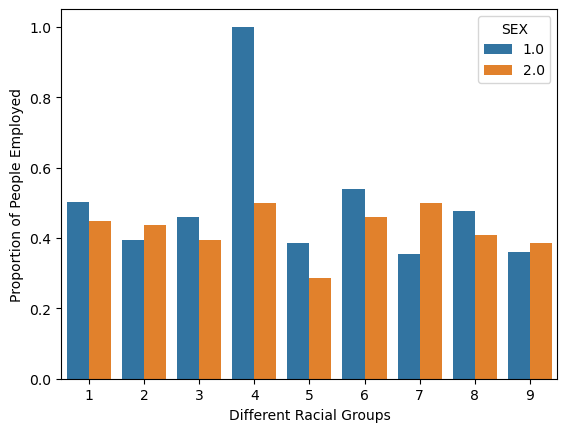

In [26]:
bplot = sns.barplot(data=df, x="group", y="label", hue="SEX", errorbar=('ci', 0))
bplot.set(xlabel="Different Racial Groups", ylabel="Proportion of People Employed")
plt.show(bplot)

Therefore, it is apparent that the proportion of women who are employed, is less than the proportion of men who are employed, in almost all racial groups except racial group 2, 7, and 9. Not only that, some racial groups have a really high disparity between the proportion of men who are employed versus the proportion of women who are employed. For instance, in racial group 4: the proportion of men who are employed is roughly 100%, while the proportion of women who are employed is only 50%.

# Training the Model
Now that we have answered the basic descriptive questions, we are ready to train our model on the training data. For this blog post, the chosen machine learning model is: <i>Logistic Regression</i>, and we will be tuning the polynomial features (number of degrees) in our <i>Logistic Regression</i> model. Therefore, our workflow is going to be:
<ol>
    <li> Creating a function that will utilize <i>Pipeline</i> to make it easier for us to construct a <i>Logistic Regression</i> model with certain number of polynomial features (a certain number of degrees)
    <li> Using cross-validation to select the best degree (number of polynomial features)
    <li> Creating a Logistic Regression model with the best number of degrees that we found in Step (2) and fitting it on our <i>training data</i>
    <li> Checking the performance of our model on the <i>testing data</i>
</ol>

Let us get started with creating the function which utilizes Pipeline, for easier construction of our Logistic Regression models:

In [27]:
def polyLR(deg):
  return Pipeline([("poly", PolynomialFeatures(degree = deg)),
                   ("LR", LogisticRegression(penalty = None, max_iter = 1000))])

Now, we can use cross-validation to select which degree (number of polynomial features) works best for our data. The main principle behind cross-validation is that you can divide your training data into $k$ folds (chunks), and then train your model over $k-1$ chunks and then <i>validate</i> it over the last remaining chunk. Therefore, if you divide your training data into $4$ chunks - let us say - then each one of the $4$ chunks will act as the <i>validation data</i> once, with the rest of the chunks being used as <i>training data</i>. Therefore, in case of $4$ chunks, the <u>fit</u> function will be called $4$ times. Now, we can find the <i>mean</i> cross-validation score for varying degrees (number of polynomial features), and the degree which has the highest cross-validation score is most likely to perform the best on the <i>testing data</i>:

In [28]:
for deg in range(5):
    plr = polyLR(deg = deg)
    cv_scores = cross_val_score(plr, X_train, y_train, cv = 5)
    mean_score = cv_scores.mean()
    print(f"Polynomial Degree = {deg}, Score = {mean_score.round(3)}")

Polynomial Degree = 0, Score = 0.535
Polynomial Degree = 1, Score = 0.772
Polynomial Degree = 2, Score = 0.811
Polynomial Degree = 3, Score = 0.809
Polynomial Degree = 4, Score = 0.806


Therefore, for our purposes it seems that Polynomial Degree = $2$ yields the best results during our cross-validation, so we can assume that this degree is also likely to perform the best on our <i>testing data</i>. Now, we can go ahead and create a Logistic Regression model with degrees = $2$:

In [29]:
plr = polyLR(deg = 2)
plr.fit(X_train, y_train)
print(f"Score on Training Data: {plr.score(X_train, y_train).round(3)}")

Score on Training Data: 0.811


Now, finally we can check the performance of our model on the <i>testing data</i>:

In [30]:
print(f"Score on Testing Data: {plr.score(X_test, y_test).round(3)}")

Score on Testing Data: 0.811


Therefore, we can see that we achieved approximately $81$% accuracy on our <i>testing data</i>!

# Auditing the Model 
Now that our model is trained, we can perform an audit on the test data where we can answer questions on our <i>testing data</i>. It is helpful to use a confusion matrix while answering these questions. A confusion matrix, is a matrix containing information about the model's prediction and the kind of errors it makes: 
<ol>
    <li>True Negative: Negative Data + Classified Negative by Model
    <li>False Positive: Negative Data + Wrongly Classified Positive by Model
    <li>False Negative: Positive Data + Wrongly Classified Negative by Model
    <li>True Positive: Positive Data + Classified Positive by Model
</ol>

In [31]:
y_pred = plr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(f"The Confusion Matrix:\n {cm}")
tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
print(f"\nTrue Negative: {tn}")
print(f"False Positive: {fp}")
print(f"False Negative: {fn}")
print(f"True Positive: {tp}")

The Confusion Matrix:
 [[16235  4952]
 [ 2491 15716]]

True Negative: 16235
False Positive: 4952
False Negative: 2491
True Positive: 15716


That above is our confusion matrix with the information we talked about above. Now, it is useful to define some concepts and associated formulae:
<ol>
    <li><u>Overall Accuracy</u>: proportion of correct predictions made over the total number of predictions made <br><br><center>$\text{Overall Accuracy} = \frac{TN + TP}{TN + TP + FP + FN}$</center><br>
    <li><u>Positive Predictive Value (PPV)</u>: probability that a positive prediction made by the model is actually correct <br><br><center>$\text{PPV} = \frac{TP}{TP + FP}$</center><br>
    <li><u>False Positive Rate (FPR)</u>: proportion of negative examples that were incorrectly classified as positve<br><br><center>$\text{FPR} = \frac{FP}{FP + TN}$</center><br>
    <li><u>False Negative Rate (FNR)</u>: proportion of positive examples that were incorrectly classified as negative <br><br><center>$\text{FNR} = \frac{FN}{FN + TP}$</center>
</ol>

### Overall Measures
1. What is the overall accuracy of our model?

In [33]:
overallAccuracy = ((tn + tp)/(tn + tp + fp + fn)).round(3)
print(f"Overall Accuracy of the Model is {np.round(overallAccuracy*100,3)}%")

Overall Accuracy of the Model is 81.1%


2. What is the Positive Predictive Value (PPV) of our model?

In [34]:
ppv = ((tp)/(tp + fp)).round(3)
print(f"PPV of the Model: {ppv}")
print(f"This means that {ppv} of all positive predictions made by the model are actually correct!")

PPV of the Model: 0.76
This means that 0.76 of all positive predictions made by the model are actually correct!


3. What are the overall False Positive and False Negative Rates (FPR and FNR) for our model?

In [35]:
fpr = ((fp)/(fp + tn)).round(3)
fnr = ((fn)/(fn + tp)).round(3)
print(f"FPR of the Model: {fpr}")
print(f"This means that {fpr} of all negative examples were wrongly classified as positive!")
print(f"\nFNR of the Model: {fnr}")
print(f"This means that {fnr} of all positive examples were wrongly classified as negative!")

FPR of the Model: 0.234
This means that 0.234 of all negative examples were wrongly classified as positive!

FNR of the Model: 0.137
This means that 0.137 of all positive examples were wrongly classified as negative!


### By-Group Measures
Now, we can go ahead and look at the: Overall Accuracy, PPV, FPR, and FNR for each the 9 subgroups (the different racial groups). We cannot calculate the statistics for <i>Group 4: Alaskan Natives</i> due to lack of sufficient sample:

In [39]:
for i in list(range(1,4)) + list(range(5, 10)):
    print(f"\nGroup {i}:")
    ix = X_test[group_test == i, :]
    y_testx = y_test[group_test == i]
    y_predx = plr.predict(ix)
    cm = confusion_matrix(y_testx, y_predx)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    overallAccuracy = (((tn + tp)/(tn + tp + fp + fn)) * 100).round(2)
    ppv = ((tp)/(tp + fp)).round(3)
    fpr = ((fp)/(fp + tn)).round(3)
    fnr = ((fn)/(fn + tp)).round(3)
    print(f"Overall Accuracy: {overallAccuracy}%")
    print(f"PPV of the Model: {ppv}")
    print(f"This means that {ppv} of all positive predictions made by the model are actually correct!")
    print(f"FPR of the Model: {fpr}")
    print(f"This means that {fpr} of all negative examples were wrongly classified as positive!")
    print(f"FNR of the Model: {fnr}")
    print(f"This means that {fnr} of all positive examples were wrongly classified as negative!")


Group 1:
Overall Accuracy: 81.62%
PPV of the Model: 0.772
This means that 0.772 of all positive predictions made by the model are actually correct!
FPR of the Model: 0.223
This means that 0.223 of all negative examples were wrongly classified as positive!
FNR of the Model: 0.139
This means that 0.139 of all positive examples were wrongly classified as negative!

Group 2:
Overall Accuracy: 80.6%
PPV of the Model: 0.734
This means that 0.734 of all positive predictions made by the model are actually correct!
FPR of the Model: 0.24
This means that 0.24 of all negative examples were wrongly classified as positive!
FNR of the Model: 0.133
This means that 0.133 of all positive examples were wrongly classified as negative!

Group 3:
Overall Accuracy: 73.4%
PPV of the Model: 0.667
This means that 0.667 of all positive predictions made by the model are actually correct!
FPR of the Model: 0.278
This means that 0.278 of all negative examples were wrongly classified as positive!
FNR of the Model:

### Bias Measures
##### <font color="green">Is the model approximately <i>calibrated</i>?</font>
The results clearly show that the <i>PPV</i> varies across the different racial groups. Therefore, our model is not calibrated. For example, if we compared Group 1 (White only): PPV = $0.772$ and Group 2 (Black only): PPV = $0.734$. Therefore, $\text{PPV}_\text{White} > \text{PPV}_\text{Black}$, which means that the probability that a positive prediction made by the model is correct, is higher for white people, compared to black people. 

##### <font color="green">Does the model satisfy approximate <i>error rate balance</i>?</font>
The model does not satisfy approximate <i>error rate balance</i>. This is because the <i>FPR</i> and <i>FNR</i> is different across different racial groups. For example, analyzing Group 1 (White only) and Group 2 (Black only): $(\text{FPR}_\text{White}  = 0.223) < (\text{FPR}_\text{Black}= 0.24)$, and $(\text{FNR}_\text{White}  = 0.139) > (\text{FNR}_\text{Black}= 0.133)$. Therefore, for FPR: the model is more likely to wrongly classify negative examples (not employed) as positive (employed) for Black people compared to White people. For FNR: the model is more likely to wrongly classify positive examples (employed) as negative (not employed) for White people compared to Black people. Therefore, the model makes different types of mistakes more often, across different racial groups.

##### <font color="green">Does the model satisfy <i>statistical parity</i>?</font>
Since, our model has different values of <i>PPV</i> for different racial groups - our model does not satisfy <i>statistical parity</i>!

# Concluding Discussions
##### <font color="green">What groups of people could stand to benefit from a system? hat kinds of companies might want to buy your model for commercial use?</font>
Since this model predicts whether a person is employed or not, based on other demographic factors. This model could be used to automate or cross-check the process of providing unemployment benefits to individuals. Since this model is more likely to classify unemployed Black people as employed, and more likely to classify employed White people as unemployed, if there were a model which gave people unemployment benefits based on the results of this model - White people would benefit!

##### <font color="green">What could be the impact of deploying your model for large-scale prediction in commercial or governmental settings? Do you feel that your model displays problematic bias?</font>
Deploying a model like this for large-scale prediction in commercial or governmental settings will be problematic. This is because, as discussed above: the model will make different kinds of mistakes for different racial groups. Therefore, certain racial groups will benefit more than others - for instance, if the model is used to decide who gets unemployment benefits. Furthermore, this model displays problematic bias. As discussed in the <i>Bias Measures</i> the model is not (does not satisfy):
<ol>
    <li> Calibrated: probability that a positive prediction made by model is correct is different across racial groups
    <li> Approximate Error Rate Balance: will make different kinds of mistakes for different racial groups
    <li> Statistical Parity: model does not satisfy Statistical Parity (different <i>PPV</i>) for different racial groups
</ol>

##### <font color="green">Are there other potential problems associated with deploying your model that make you uncomfortable? How would you propose addressing some of these problems?</font>
If this model were to be used for government purposes: deciding unemployment benefits (mentioned above), I would not feel very comfortable. This is because the model first of all has its own problems and biases, and furthermore automating a process which affects an individual (and humans) so much is very inhumane, as the errors of the model can deeply affect people. If the model did not exhibit the problematic biases discussed above, then maybe the model would be slightly better for deployment. However, it would still not be ideal according to me.